# Parameter Inference

Here we infer the parameters of the systems we have observed.  Because of the use of print statements in `infer.py`, this notebook must be opened in Python 3 mode.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import infer
import pymc3 as pm
import scipy.stats as ss
import seaborn as sns
import sys
import theano
import theano.tensor as tt
import theano.tensor.extra_ops as te
from tqdm import tqdm_notebook
from true_params import uncert

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

We will want to impose a prior on $\Theta$ that is about right.  A Gaussian gets pretty close:

In [3]:
with h5py.File('thetas.h5', 'r') as f:
    mu_t = mean(f['Theta'])
    sigma_t = std(f['Theta'])
    thetas = array(f['Theta'])

Surprisingly, this is pretty good:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


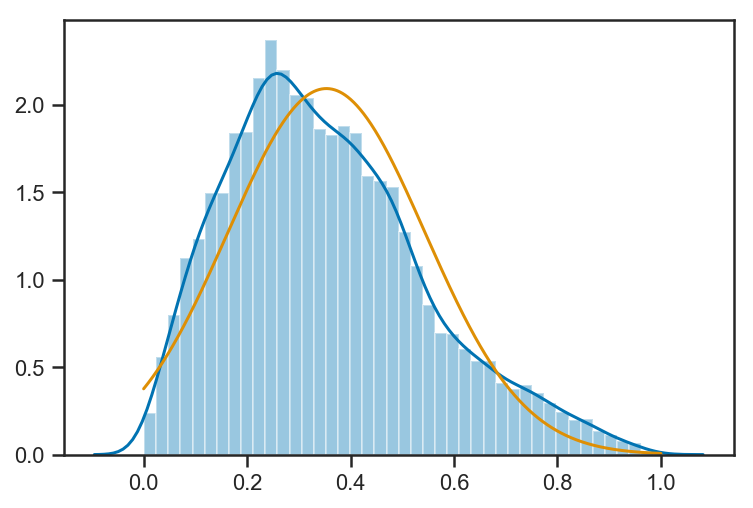

In [4]:
sns.distplot(thetas)
xs = linspace(0, 1, 1000)
plot(xs, ss.norm(loc=mu_t, scale=sigma_t).pdf(xs))

The program `infer.py` actually does the heavy lifting, but you can duplicate the fits for individual systems here:

In [5]:
i = 544

with infer.m:
    infer.mco.set_value(infer.mcobs[i])
    infer.eto.set_value(infer.etaobs[i])
    infer.ro.set_value(infer.rhoobs[i])
    infer.to.set_value(infer.thetaobs[i])

    infer.sigma_mc.set_value(infer.smcs[i])
    infer.sigma_eta.set_value(infer.sets[i])
    infer.sigma_rho.set_value(infer.srhs[i])
    infer.sigma_theta.set_value(infer.sths[i])
    
    trace = pm.sample(draws=1000, tune=1000, njobs=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, dl, eta, mcdet]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:10<00:00, 785.84draws/s]


/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` inst

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3265ea90>,
      dtype=object)

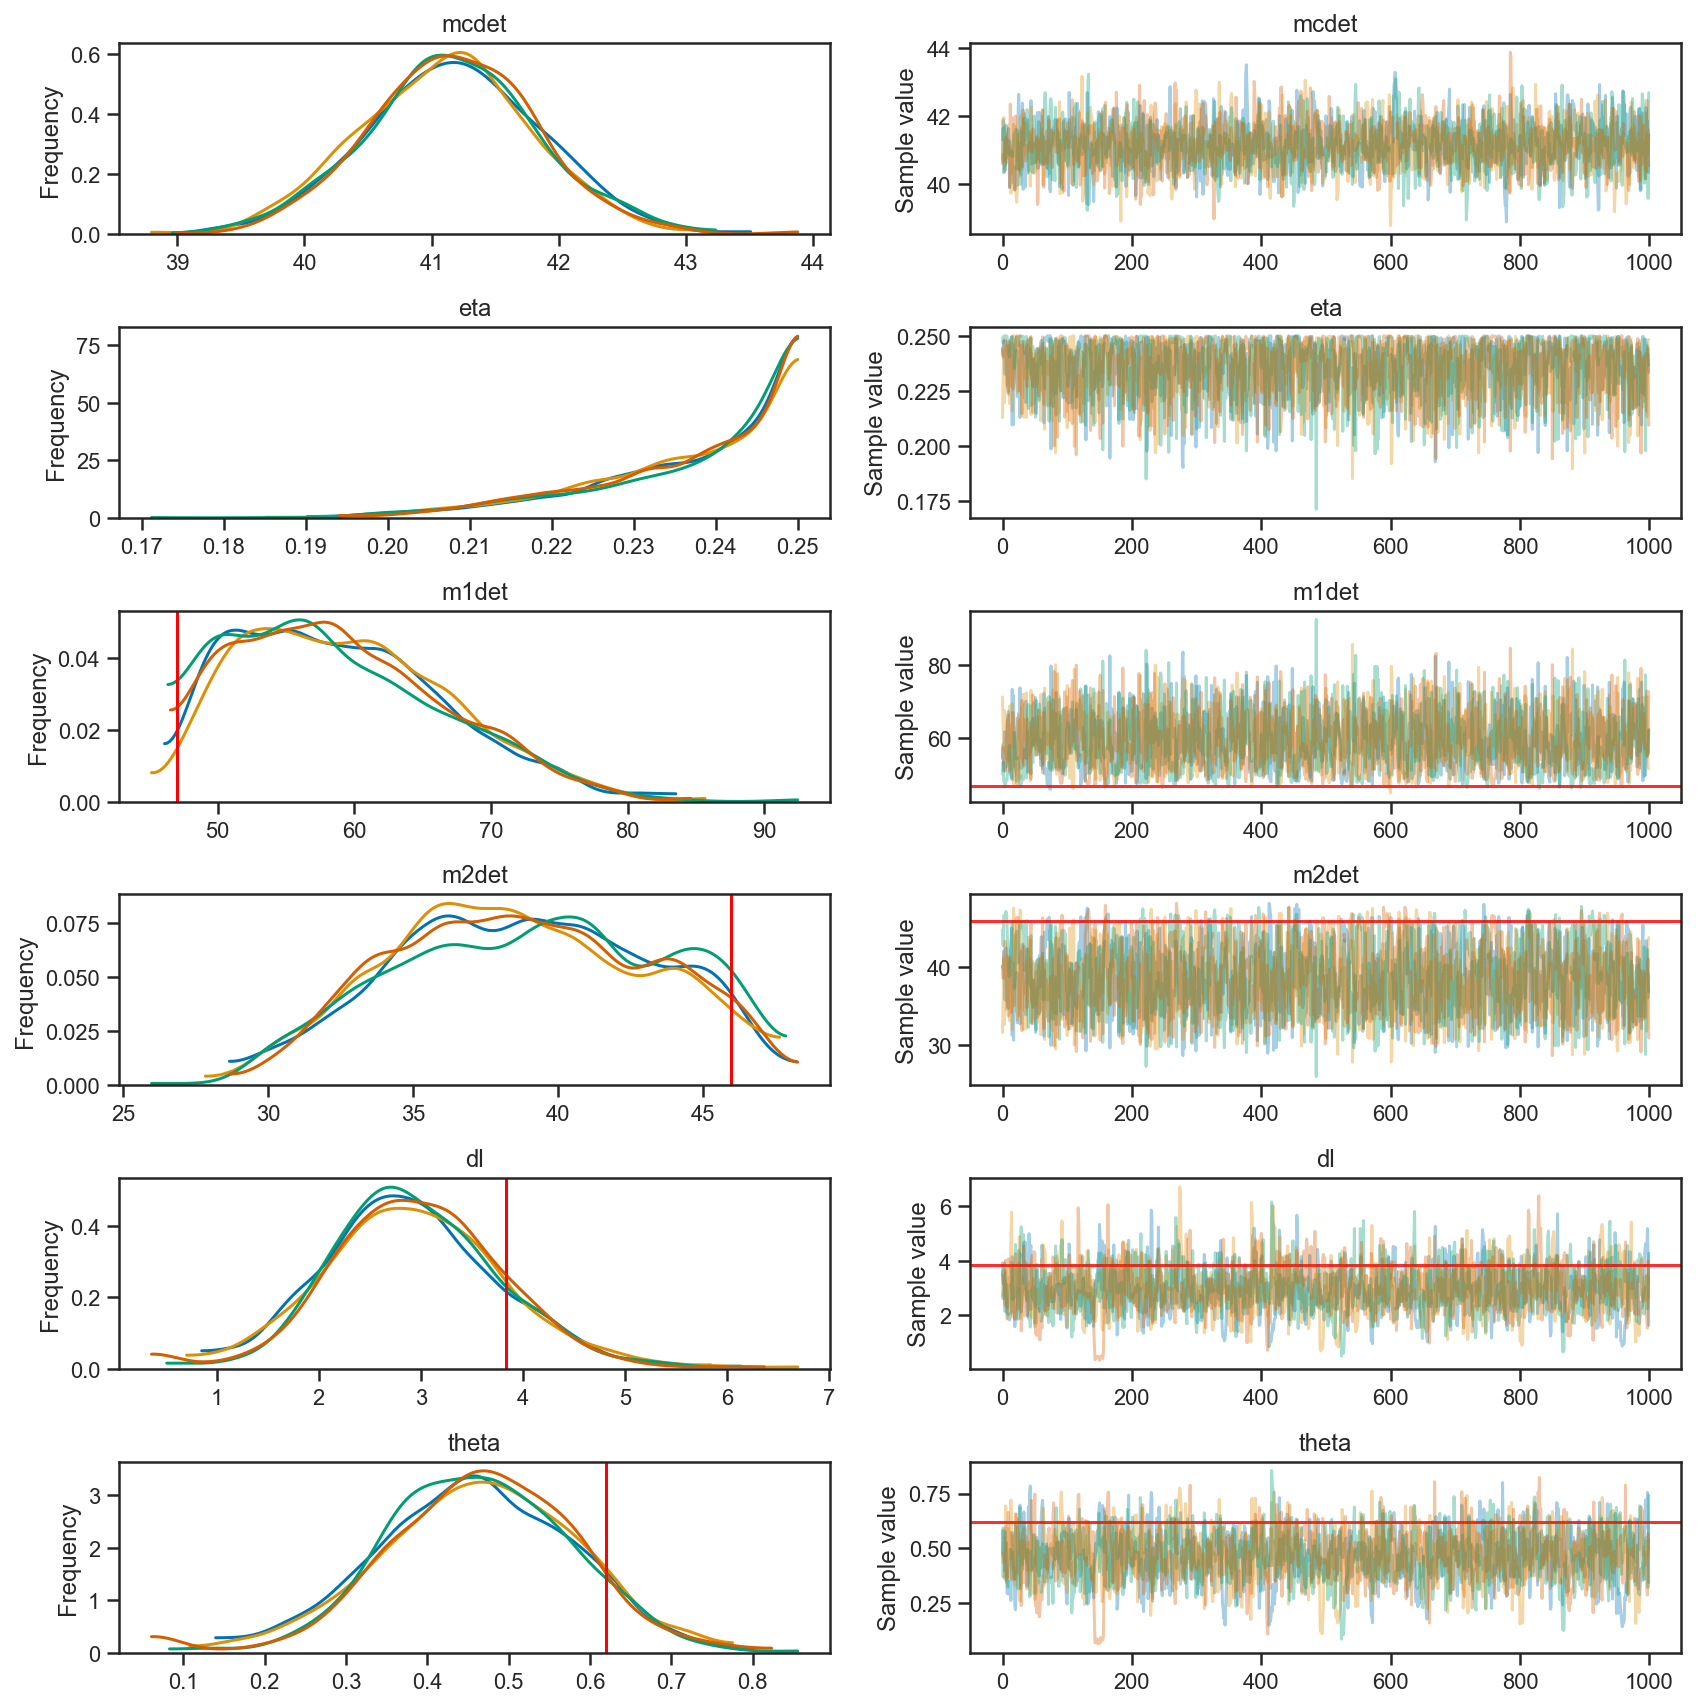

In [6]:
pm.traceplot(trace, lines={'m1det': infer.m1s[i]*(1+infer.zs[i]), 'm2det': infer.m2s[i]*(1+infer.zs[i]), 'dl': Planck15.luminosity_distance(infer.zs[i]).to(u.Gpc).value, 'theta': infer.thetas[i]})

## Checking results

In [3]:
with h5py.File('observations.h5', 'r') as f:
    m1s = array(f['m1s'])
    m2s = array(f['m2s'])
    zs = array(f['zs'])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1det_samples = array(f['posteriors']['m1det'])
    m2det_samples = array(f['posteriors']['m2det'])
    dl_samples = array(f['posteriors']['dl'])
    theta_samples = array(f['posteriors']['theta'])

First, let's look at some z-scores for $m_1$, $m_2$, and $d_L$:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '$p\\left( z_{d_L} \\right)$')

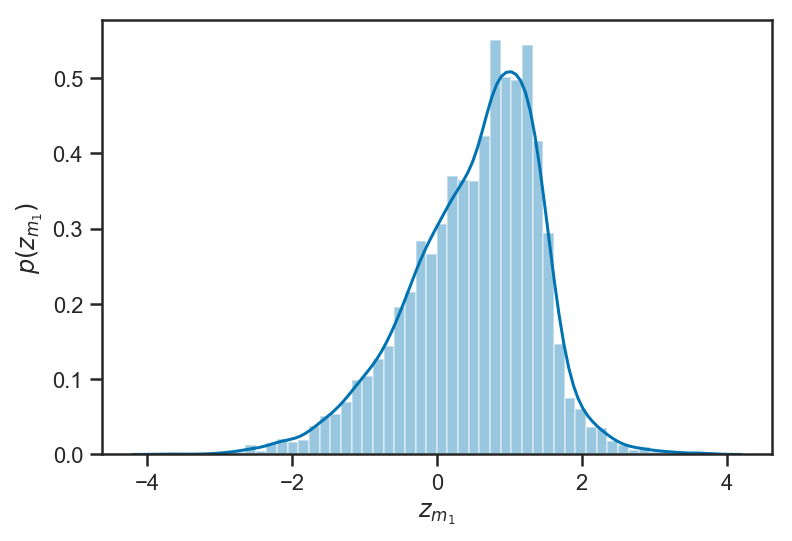

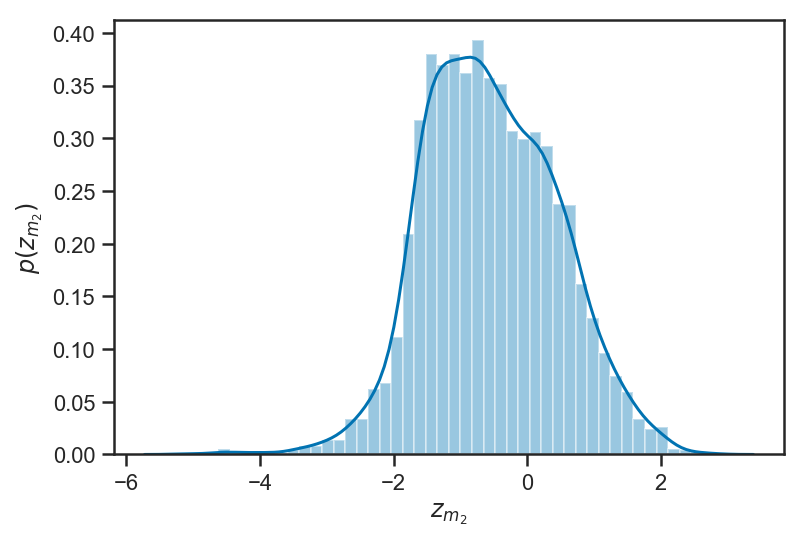

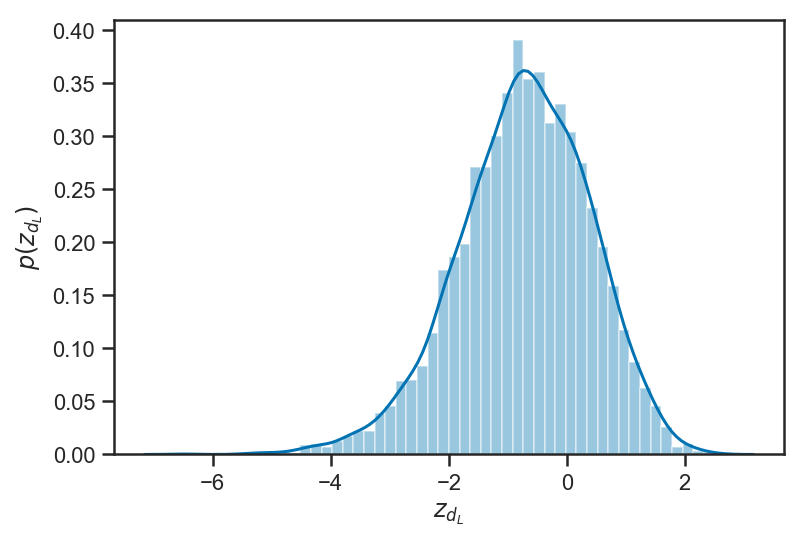

In [8]:
zscore_m1 = mean(m1det_samples - m1s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m1det_samples, axis=1)
sns.distplot(zscore_m1)
xlabel(r'$z_{m_1}$')
ylabel(r'$p\left( z_{m_1} \right)$')

figure()
zscore_m2 = mean(m2det_samples - m2s[:,newaxis]*(1+zs[:,newaxis]), axis=1)/std(m2det_samples, axis=1)
sns.distplot(zscore_m2)
xlabel(r'$z_{m_2}$')
ylabel(r'$p\left( z_{m_2} \right)$')

figure()
zscore_dl = mean(dl_samples - dls[:,newaxis], axis=1)/std(dl_samples, axis=1)
sns.distplot(zscore_dl)
xlabel(r'$z_{d_L}$')
ylabel(r'$p\left( z_{d_L} \right)$')

It is not surprising that we find that the $m_1$ samples are biased high (since the $m_1$ population density falls below the flat distribution at large masses), that the $m_2$ samples are more un-biased (since the population is---sort of---flat) and that the $d_L$ samples are biased low (because the true population is increasing faster than flat with $d_L$).  Reassuringly, we don't see any outliers.

Another test we can do is to check the median uncertainties in masses and distances, and compare against GW170814.  The agreement is striking (well, we tuned it to be this way).

In [9]:
print('median 90% CI in log(m1) is {:.2f}'.format(median(quantile(log(m1det_samples), 0.95, axis=1) - quantile(log(m1det_samples), 0.05, axis=1))))
print('median 90% CI in log(m2) is {:.2f}'.format(median(quantile(log(m2det_samples), 0.95, axis=1) - quantile(log(m2det_samples), 0.05, axis=1))))
print('median 90% CI in log(dL) is {:.2f}'.format(median(quantile(log(dl_samples), 0.95, axis=1) - quantile(log(dl_samples), 0.05, axis=1))))

print()

print('GW170814 had {:.2f}, {:.2f}, {:.2f}'.format(log(30.5+5.7)-log(30.5-3.0), log(25.3+2.8)-log(25.3-4.2), log(540+130)-log(540-210)))

median 90% CI in log(m1) is 0.34
median 90% CI in log(m2) is 0.31
median 90% CI in log(dL) is 0.70

GW170814 had 0.27, 0.29, 0.71


In order to generate reliable selection effects, we need a dLmax that encloses the entire sample.

In [10]:
print('maximum estimated dL is {:.1f} Gpc'.format(np.max(dl_samples)))

maximum estimated dL is 15.9 Gpc


We want to be sure that we are accurately representing the covariance structure of the posterior sampling; so let's calculate the matrix norm difference between the full covariance and a covariance estimated from a subsample.  When this number is (almost always) small, then we have enough samples.

In [10]:
cnorms = []
nsamp = 128

for i in range(m1det_samples.shape[0]):
    pts = column_stack((m1det_samples[i,:], m2det_samples[i,:], dl_samples[i,:]))
    
    c = cov(pts, rowvar=False)
    
    s = random.choice(pts.shape[0], size=nsamp, replace=False)
    
    cs = cov(pts[s,:], rowvar=False)
    
    sig = sqrt(diag(c))
    scale = outer(sig, sig)
    
    cnorms.append(np.max(np.abs((c-cs)/scale)))

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


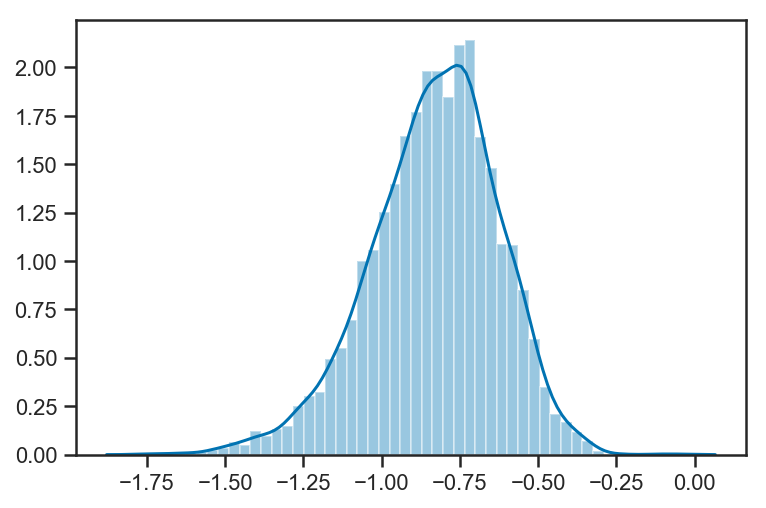

In [11]:
sns.distplot(log10(cnorms))

## Setting the Number of Samples to Use

We will adjust this number later, but for now, let's stick 128 samples as the default number to use for each event:

In [4]:
with h5py.File('observations.h5', 'a') as f:
    g = f['posteriors']
    
    g.create_dataset('nsamp', data=128*np.ones(len(m1s), dtype=np.int), compression='gzip', shuffle=True)